<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install -e /Users/ruxu/Desktop/AA228/Project_3/FinRL


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
zsh:1: command not found: apt-get
Obtaining file:///Users/ruxu/Desktop/AA228/Project_3/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/4g/ysbz5xb13q91647czp8lcqg4001mtg/T/pip-install-ho0paufy/elegantrl_93fa8608d5ff4295848ae99d67ca0d49
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/4g/ysbz5xb13q91647czp8lcqg4001mtg/T/pip-install-ho0paufy/elegantrl_93fa8608d5ff4295848ae99d67ca0d49
  Resolved https://github.com/AI4Finance-Foundation/Elega

In [1]:
!pip install -e /Users/ruxu/Desktop/AA228/Project_3/FinRL

Obtaining file:///Users/ruxu/Desktop/AA228/Project_3/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/4g/ysbz5xb13q91647czp8lcqg4001mtg/T/pip-install-ropr2jrl/elegantrl_bda7e94d486a4a959ba1db6c885d9aeb
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/4g/ysbz5xb13q91647czp8lcqg4001mtg/T/pip-install-ropr2jrl/elegantrl_bda7e94d486a4a959ba1db6c885d9aeb
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9105 sha256=fd3e72f5afc4cd3a1

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent,DRLStackingAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.agents.stablebaselines3.models import hyperparameterized_model_name, MODELS


from pprint import pprint

import sys
import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2022-11-10'
# TEST_START_DATE = '2022-11-11'
# TEST_END_DATE = '2024-11-11'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

INDICATORS = ['log-ret', 'rsi_30', 'dx_30', 'close_-7_s', 'close_-14_s', 'close_-30_s', 'close_-60_s']

CUSTOM_TICKER = [
    "INTC",
    "F",
    "PARA",
    "LVS"
]

In [6]:
# test dummy stock
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

INDICATORS = ['close_-1_s','close_-2_s','close_-3_s','close_-4_s','close_-5_s', 'close_0_s']
CUSTOM_TICKER = [
    "INTC"
]

def dummy_stock(n, type='flat'):
    if type == 'flat':
        return [10]*n
    if type == 'triangle':
       return ((list(np.arange(100,2000,100)) + list(np.arange(2000,100,-100)))*n)[0:n]
    if type == 'up':
       return list(np.arange(10,20000,(20000-10)/n))[0:n]
    if type == 'down':
       return list(np.arange(20000,10,(10-20000)/n))[0:n]

if True:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    df['close'] = dummy_stock(df.shape[0], type='triangle')
    df['open'] = dummy_stock(df.shape[0], type='triangle')
    df['low'] = dummy_stock(df.shape[0], type='triangle')
    df['high'] = dummy_stock(df.shape[0], type='triangle')
    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed['close_-1_s'] = 100*(processed['close']-processed['close_-1_s'])/processed['close_-1_s']
    processed['close_-2_s'] = 100*(processed['close']-processed['close_-2_s'])/processed['close_-2_s']
    processed['close_-3_s'] = 100*(processed['close']-processed['close_-3_s'])/processed['close_-3_s']
    processed['close_-4_s'] = 100*(processed['close']-processed['close_-4_s'])/processed['close_-4_s']
    processed['close_-5_s'] = 100*(processed['close']-processed['close_-5_s'])/processed['close_-5_s']

[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3311, 8)
Successfully added technical indicators
Successfully added turbulence index


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [8]:
if False:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed['log-ret'] = 100*processed['log-ret']
    processed['close_-7_s'] = 100*(processed['close_-7_s'] - processed['close'])/processed['close_-7_s']
    processed['close_-14_s'] =  100*(processed['close_-14_s'] - processed['close'])/processed['close_-14_s']
    processed['close_-30_s'] =  100*(processed['close_-30_s'] - processed['close'])/processed['close_-30_s']
    processed['close_-60_s'] =  100*(processed['close_-60_s'] - processed['close'])/processed['close_-60_s']


    processed.to_csv("datasets/processed.csv", index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (13244, 8)
Successfully added technical indicators
Successfully added turbulence index


In [33]:
state_space

9

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [7]:
processed

date  open  high  low  close    volume   tic  day  close_-1_s  \
0     2010-01-04   100   100  100    100  47800900  INTC    0    0.000000   
1     2010-01-05   200   200  200    200  52357700  INTC    1  100.000000   
2     2010-01-06   300   300  300    300  40037400  INTC    2   50.000000   
3     2010-01-07   400   400  400    400  54041500  INTC    3   33.333333   
4     2010-01-08   500   500  500    500  48234700  INTC    4   25.000000   
...          ...   ...   ...  ...    ...       ...   ...  ...         ...   
3306  2023-02-22   100   100  100    100  89195300  INTC    2  -50.000000   
3307  2023-02-23   200   200  200    200  56473200  INTC    3  100.000000   
3308  2023-02-24   300   300  300    300  44089900  INTC    4   50.000000   
3309  2023-02-27   400   400  400    400  37657000  INTC    0   33.333333   
3310  2023-02-28   500   500  500    500  50255300  INTC    1   25.000000   

      close_-2_s  close_-3_s  close_-4_s  close_-5_s  close_0_s  turbulence  
0       0.000000    0.000000         0.0    0.000000        100    0.000000  
1     100.000000  100.000000       100.0  100.000000        200    0.000000  
2     200.000000  200.000000       200.0  200.000000        300    0.000000  
3     100.000000  300.000000       300.0  300.000000        400    0.000000  
4      66.666667  150.000000       400.0  400.000000        500    0.000000  
...          ...         ...         ...         ...        ...         ...  
3306  -66.666667  -75.000000       -80.0  -83.333333        100    4.965761  
3307    0.000000  -33.333333       -50.0  -60.000000        200   17.821294  
3308  200.000000   50.000000         0.0  -25.000000        300    3.987328  
3309  100.000000  300.000000       100.0   33.333333        400    1.664761  
3310   66.666667  150.000000       400.0  150.000000        500    0.885011  

[3311 rows x 15 columns]

In [8]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 9


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [9]:
import random
import copy
def generate_hyperparams_list_from_code(num_variations=5, duplication=4):
    hyperparams_list = []

    # PPO Variations
    PPO_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3],
        'n_steps': [256, 512, 1024, 2048],
        'batch_size': [64, 128],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3],
        'clip_range': [0.2, 0.3],
        'gae_lambda': [0.95, 0.98]
    }

    # A2C Variations
    A2C_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3, 0.0007],
        'n_steps': [5, 10, 20],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3, 0.005],
        'normalize_advantage': [True, False],
        'use_rms_prop': [True, False]
    }

    # DDPG Variations
    DDPG_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # SAC Variations
    SAC_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'ent_coef': ['auto'],
    }

    # TD3 Variations
    TD3_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # Timesteps Variations
    timesteps_variations = {
        'a2c': [10000],
        'ppo': [10000],
        'ddpg': [10000],
        'sac': [10000],
        'td3': [10000]
    }

    hyperparams_list = []
    for i in range(num_variations):
        A2C_kwargs = {k: random.choice(v) for k, v in A2C_variations.items()}
        PPO_kwargs = {k: random.choice(v) for k, v in PPO_variations.items()}
        DDPG_kwargs = {k: random.choice(v) for k, v in DDPG_variations.items()}
        SAC_kwargs = {k: random.choice(v) for k, v in SAC_variations.items()}
        TD3_kwargs = {k: random.choice(v) for k, v in TD3_variations.items()}
        timesteps_dict = {k: random.choice(v) for k, v in timesteps_variations.items()}

        # Assign a unique name to each set
        for j in range(duplication):
            name = f"variant_{j+1}"
            print(name)

            A2C_kwargs['name'] = name
            PPO_kwargs['name'] = name
            DDPG_kwargs['name'] = name
            SAC_kwargs['name'] = name
            TD3_kwargs['name'] = name

            hyperparam = {
                'A2C_model_kwargs': A2C_kwargs,
                'PPO_model_kwargs': PPO_kwargs,
                'DDPG_model_kwargs': DDPG_kwargs,
                'SAC_model_kwargs': SAC_kwargs,
                'TD3_model_kwargs': TD3_kwargs,
                'timesteps_dict': timesteps_dict
            }

            hyperparams_list.append(copy.deepcopy(hyperparam))

    return hyperparams_list

In [10]:
hyperparams_list = generate_hyperparams_list_from_code(num_variations=5, duplication=5)

variant_1
variant_2
variant_3
variant_4
variant_5
variant_1
variant_2
variant_3
variant_4
variant_5
variant_1
variant_2
variant_3
variant_4
variant_5
variant_1
variant_2
variant_3
variant_4
variant_5
variant_1
variant_2
variant_3
variant_4
variant_5


In [11]:
hyperparams_list

[{'A2C_model_kwargs': {'learning_rate': 1e-05,
   'n_steps': 10,
   'gamma': 0.98,
   'ent_coef': 1e-05,
   'normalize_advantage': False,
   'use_rms_prop': False,
   'name': 'variant_1'},
  'PPO_model_kwargs': {'learning_rate': 1e-05,
   'n_steps': 1024,
   'batch_size': 128,
   'gamma': 0.98,
   'ent_coef': 1e-05,
   'clip_range': 0.2,
   'gae_lambda': 0.95,
   'name': 'variant_1'},
  'DDPG_model_kwargs': {'learning_rate': 0.0001,
   'batch_size': 64,
   'buffer_size': 1000000,
   'tau': 0.01,
   'gamma': 0.99,
   'train_freq': 1,
   'action_noise': 'ornstein_uhlenbeck',
   'name': 'variant_1'},
  'SAC_model_kwargs': {'learning_rate': 0.0001,
   'batch_size': 64,
   'buffer_size': 100000,
   'tau': 0.01,
   'gamma': 0.99,
   'train_freq': 10,
   'ent_coef': 'auto',
   'name': 'variant_1'},
  'TD3_model_kwargs': {'learning_rate': 0.0001,
   'batch_size': 128,
   'buffer_size': 1000000,
   'tau': 0.005,
   'gamma': 0.98,
   'train_freq': 10,
   'action_noise': 'normal',
   'name': 'var

In [12]:
import ray
import random
import numpy as np
import torch

ray.init(ignore_reinit_error=True)

@ray.remote
def run_ensemble_with_params(hyperparams, seed, processed):

    #np.random.seed(seed)
    #random.seed(seed)
    #torch.manual_seed(seed)
    rebalance_window = 63
    validation_window = 63

    A2C_model_kwargs = hyperparams['A2C_model_kwargs']
    PPO_model_kwargs = hyperparams['PPO_model_kwargs']
    DDPG_model_kwargs = hyperparams['DDPG_model_kwargs']
    SAC_model_kwargs = hyperparams['SAC_model_kwargs']
    TD3_model_kwargs = hyperparams['TD3_model_kwargs']
    timesteps_dict = hyperparams['timesteps_dict']

    env_kwargs = {
        "hmax": 1000,
        "initial_amount": 1000000,
        "buy_cost_pct": 0.001,
        "sell_cost_pct": 0.001,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1,
        "print_verbosity":100,
    }

    # Instantiate and run the ensemble agent
    ensemble_agent = DRLEnsembleAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
        val_test_period=(TEST_START_DATE, TEST_END_DATE),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )

    df_summary = ensemble_agent.run_ensemble_strategy(
        A2C_model_kwargs,
        PPO_model_kwargs,
        DDPG_model_kwargs,
        SAC_model_kwargs,
        TD3_model_kwargs,
        timesteps_dict
    )

    return df_summary

2024-12-02 21:32:25,253	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-02 21:32:28,923	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [27]:
# stacking agent
import ray
import random
import numpy as np
import torch

ray.init(ignore_reinit_error=True)

@ray.remote
def run_stacking_with_params(hyperparams, seed, processed):

    #np.random.seed(seed)
    #random.seed(seed)
    #torch.manual_seed(seed)
    rebalance_window = 63
    validation_window = 63

    model_kwargs = hyperparams['A2C_model_kwargs']
    timesteps_dict = hyperparams['timesteps_dict']

    env_kwargs = {
        "hmax": 1000,
        "initial_amount": 1000000,
        "buy_cost_pct": 0.001,
        "sell_cost_pct": 0.001,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1,
        "print_verbosity":100,
    }

    # Instantiate and run the stacking agent
    stacking_agent = DRLStackingAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
        val_test_period=(TEST_START_DATE, TEST_END_DATE),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )

    df_summary = stacking_agent.run_stack_strategy(
        model_kwargs, timesteps_dict
    )

    return df_summary

2024-12-02 22:30:28,281	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [28]:
seeds = [42]
futures = []

for seed in seeds:
    for hyperparams in hyperparams_list:
        future = run_stacking_with_params.remote(
            hyperparams,
            seed,
            processed
        )
        futures.append(future)

results = ray.get(futures)
for df_summary in results:
    print(df_summary)

RayTaskError(NameError): [36mray::run_stacking_with_params()[39m (pid=89454, ip=127.0.0.1)
  File "/var/folders/4g/ysbz5xb13q91647czp8lcqg4001mtg/T/ipykernel_83003/2085632926.py", line 35, in run_stacking_with_params
NameError: name 'DRLStackingAgent' is not defined

In [32]:
processed

date  open  high  low  close    volume   tic  day  close_-1_s  \
0     2010-01-04   100   100  100    100  47800900  INTC    0    0.000000   
1     2010-01-05   200   200  200    200  52357700  INTC    1  100.000000   
2     2010-01-06   300   300  300    300  40037400  INTC    2   50.000000   
3     2010-01-07   400   400  400    400  54041500  INTC    3   33.333333   
4     2010-01-08   500   500  500    500  48234700  INTC    4   25.000000   
...          ...   ...   ...  ...    ...       ...   ...  ...         ...   
3306  2023-02-22   100   100  100    100  89195300  INTC    2  -50.000000   
3307  2023-02-23   200   200  200    200  56473200  INTC    3  100.000000   
3308  2023-02-24   300   300  300    300  44089900  INTC    4   50.000000   
3309  2023-02-27   400   400  400    400  37657000  INTC    0   33.333333   
3310  2023-02-28   500   500  500    500  50255300  INTC    1   25.000000   

      close_-2_s  close_-3_s  close_-4_s  close_-5_s  close_0_s  turbulence  
0       0.000000    0.000000         0.0    0.000000        100    0.000000  
1     100.000000  100.000000       100.0  100.000000        200    0.000000  
2     200.000000  200.000000       200.0  200.000000        300    0.000000  
3     100.000000  300.000000       300.0  300.000000        400    0.000000  
4      66.666667  150.000000       400.0  400.000000        500    0.000000  
...          ...         ...         ...         ...        ...         ...  
3306  -66.666667  -75.000000       -80.0  -83.333333        100    4.965761  
3307    0.000000  -33.333333       -50.0  -60.000000        200   17.821294  
3308  200.000000   50.000000         0.0  -25.000000        300    3.987328  
3309  100.000000  300.000000       100.0   33.333333        400    1.664761  
3310   66.666667  150.000000       400.0  150.000000        500    0.885011  

[3311 rows x 15 columns]

In [35]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

env_kwargs = {
        "hmax": 1000,
        "initial_amount": 1000000,
        "buy_cost_pct": 0.001,
        "sell_cost_pct": 0.001,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1,
        "print_verbosity":100,
    }

stacking_agent = DRLStackingAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

timesteps_dict = {'model_6' : 10000}

df_summary = stacking_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)

turbulence_threshold:  17.821294320587853


ValueError: Error: Unexpected observation shape (8,) for Box environment, please use (33,) or (n_env, 33) for the observation shape.

In [13]:
ray.shutdown()


In [14]:
seeds = [42]
futures = []

for seed in seeds:
    for hyperparams in hyperparams_list:
        future = run_ensemble_with_params.remote(
            hyperparams,
            seed,
            processed
        )
        futures.append(future)

results = ray.get(futures)
for df_summary in results:
    print(df_summary)

2024-12-02 21:32:40,081	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(run_ensemble_with_params pid=83237) ============Start Ensemble Strategy============
(run_ensemble_with_params pid=83237) ============================================
(run_ensemble_with_params pid=83237) ======Model training from:  2010-01-01 to  2021-10-04
(run_ensemble_with_params pid=83237) ==============Models Training===========
(run_ensemble_with_params pid=83237) ======a2c Training========
(run_ensemble_with_params pid=83237) Using cpu device
(run_ensemble_with_params pid=83237) Logging to tensorboard_log/d83bdab02fa8fe886511a3445f0a5359/a2c_d83bdab02fa8fe886511a3445f0a5359_126_1
(run_ensemble_with_params pid=83237) ---------------------------------
(run_ensemble_with_params pid=83237) | time/              |          |
(run_ensemble_with_params pid=83237) |    fps             | 489      |
(run_ensemble_with_params pid=83237) |    iterations      | 1        |
(run_ensemble_with_params pid=83237) |    time_elapsed    | 0        |
(run_ensemble_with_params pid=83237) |    total_tim

In [15]:
run_reports = []
for hyperparam in hyperparams_list:
    for k, v in hyperparam.items():
        if 'model_kwargs' in k:
            model_name = k.split('_')[0].lower()
            run_reports.append([hyperparameterized_model_name(model_name, v),
                        model_name, v])

performance_stats = pd.DataFrame(run_reports, columns=['hash_id', 'model_name', 'config'])

In [16]:
performance_stats

hash_id model_name  \
0    22bfb228f3b40247c910cb2e1c35e65b        a2c   
1    25c7f8b1c3aa1921aa5b8e54b74f9c1b        ppo   
2    05e8e350cdb24a4a569af5801b431ad9       ddpg   
3    18f0bf89276222d9d9f1ea1214cfae14        sac   
4    037d3d78fb4f1a03f0fd291487d43fb1        td3   
..                                ...        ...   
120  c0e429f5bdf15e8532c21b1ac37cd3ef        a2c   
121  3096594cefb584b22f9044b7455c105c        ppo   
122  c9ae6cb7c4ca38879e0f744e00cb6f94       ddpg   
123  b59dc613f09be97cbc755c582cd26f0c        sac   
124  650f4206a4f662a922bcb9421ddefe9b        td3   

                                                config  
0    {'learning_rate': 1e-05, 'n_steps': 10, 'gamma...  
1    {'learning_rate': 1e-05, 'n_steps': 1024, 'bat...  
2    {'learning_rate': 0.0001, 'batch_size': 64, 'b...  
3    {'learning_rate': 0.0001, 'batch_size': 64, 'b...  
4    {'learning_rate': 0.0001, 'batch_size': 128, '...  
..                                                 ...  
120  {'learning_rate': 0.0001, 'n_steps': 10, 'gamm...  
121  {'learning_rate': 0.0001, 'n_steps': 256, 'bat...  
122  {'learning_rate': 0.0001, 'batch_size': 128, '...  
123  {'learning_rate': 0.001, 'batch_size': 64, 'bu...  
124  {'learning_rate': 0.0001, 'batch_size': 64, 'b...  

[125 rows x 3 columns]

In [17]:
portfolio_return = []
for i, row in performance_stats.iterrows():
    r = (list(pd.read_csv(f'results/account_value_validation_{row["hash_id"]}_315.csv')['account_value'])[-1]/1000000) - 1
    portfolio_return.append(r)

performance_stats['r'] = portfolio_return


In [18]:
import hashlib
performance_stats['config_str'] = [hashlib.md5(str({z for z in x.items() if z[0] != 'name'}).encode()).hexdigest()  for x in performance_stats['config']]

In [19]:
performance_stats.sort_values(['r'])

hash_id model_name  \
4    037d3d78fb4f1a03f0fd291487d43fb1        td3   
5    d83bdab02fa8fe886511a3445f0a5359        a2c   
108  79501e0f1e3cc4d958af1a85e9d99f9a        sac   
56   bf4f647ce59780165057ea45dd257c43        ppo   
71   2b4b3e931b5378abb41f73775824cdfa        ppo   
..                                ...        ...   
112  728693994d4f664568027573af3accf5       ddpg   
102  67055bc9566485720d387b3646c90c8e       ddpg   
119  b3514a04526e0b8c7cb53585696916e1        td3   
82   7c04b9446a0b71360cddd14422521934       ddpg   
99   e9f113e59d396991a265e19424b8ca90        td3   

                                                config          r  \
4    {'learning_rate': 0.0001, 'batch_size': 128, '...  -0.819903   
5    {'learning_rate': 1e-05, 'n_steps': 10, 'gamma...  -0.573653   
108  {'learning_rate': 0.001, 'batch_size': 64, 'bu...  -0.570004   
56   {'learning_rate': 0.0001, 'n_steps': 2048, 'ba...  -0.514107   
71   {'learning_rate': 0.0001, 'n_steps': 2048, 'ba...  -0.487761   
..                                                 ...        ...   
112  {'learning_rate': 0.0001, 'batch_size': 128, '...  15.533752   
102  {'learning_rate': 0.0001, 'batch_size': 128, '...  15.602295   
119  {'learning_rate': 0.0001, 'batch_size': 64, 'b...  15.682580   
82   {'learning_rate': 0.0001, 'batch_size': 128, '...  15.752911   
99   {'learning_rate': 0.001, 'batch_size': 64, 'bu...  17.256390   

                           config_str  
4    5b6f2fc090bbcf0dd133b25a5a29cb30  
5    7e6f65f7d2936a379d05bf4020dd8f41  
108  5636b1a69b1858ada858823824babffd  
56   7b2ff21aeea36cedccdea2becc5cd8fe  
71   7b2ff21aeea36cedccdea2becc5cd8fe  
..                                ...  
112  eeeef1c01e0d2d369e302583abcb6f5b  
102  eeeef1c01e0d2d369e302583abcb6f5b  
119  76fe1477448828c243195a0642943975  
82   c965b85918d679253c743774bc5fc61f  
99   57042f0bc9086580cd66fc4a4fcbd1c4  

[125 rows x 5 columns]

In [22]:
best_models_ = {
    'a2c': 'trained_model/45bcb34f2a2bb70acde744490d43a80a_10k_315.zip',
    'ddpg': 'trained_model/7c04b9446a0b71360cddd14422521934_10k_315.zip',
    'td3': 'trained_model/e9f113e59d396991a265e19424b8ca90_10k_315.zip',
    'sac': 'trained_model/82e3208736786c850204f98dd2f8d12b_10k_315.zip',
    'ppo': 'trained_model/508cf4f679d46850266d5e59ea4b9ab2_10k_315.zip'
}



In [20]:
performance_stats.groupby('model_name').agg(
    avg=('r', 'mean'),
    std=('r', 'std')
)

avg       std
model_name                    
a2c         5.811205  3.834735
ddpg        7.988624  5.326687
ppo         3.142498  2.415038
sac         1.677204  1.697165
td3         6.058820  5.232710

In [21]:
performance_stats.to_csv("performance_stats_portfolio_5_variation_10_duplication.csv")

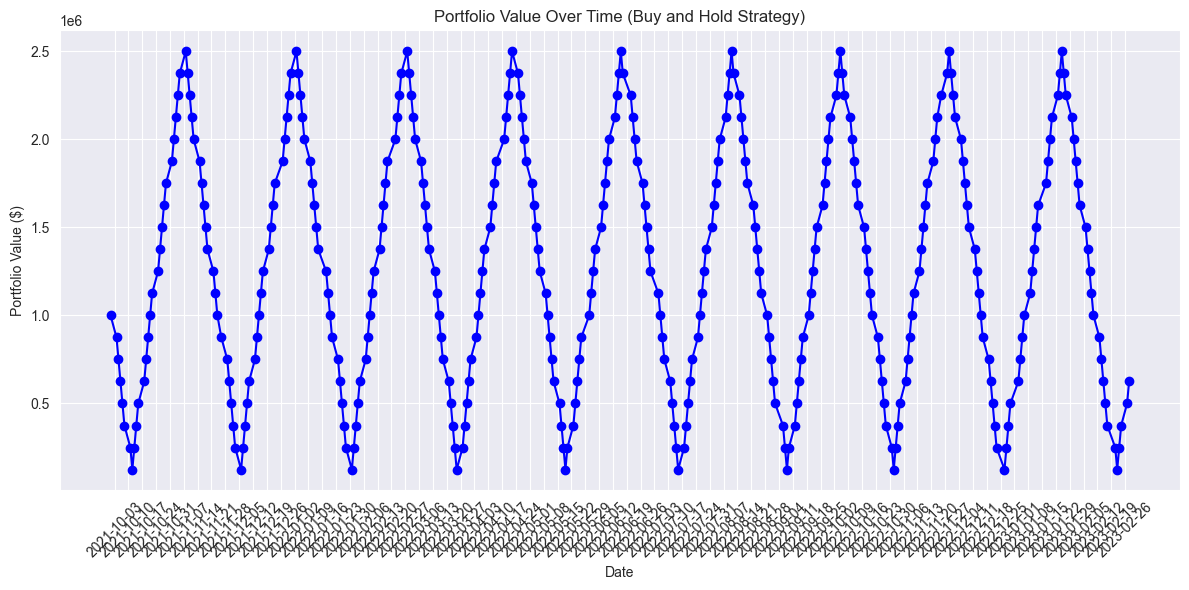

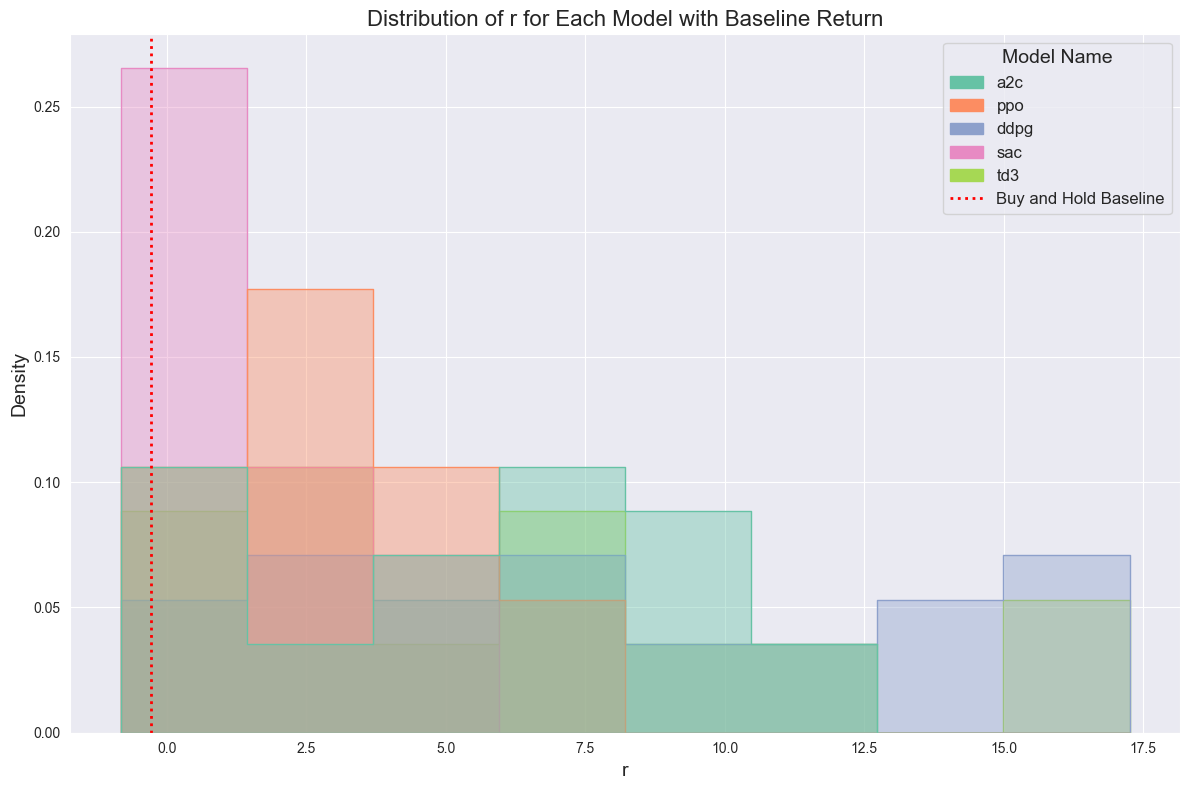

In [23]:
import seaborn as sns
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Define the baseline return
# baseline_return = 0.079  # Adjust based on your actual baseline
baseline_return = -0.28

# Initialize the plot
plt.figure(figsize=(12, 8))

# Plot the distribution with Seaborn's histplot
ax = sns.histplot(
    data=performance_stats,
    x='r',
    hue='model_name',
    kde=False,
    element='step',
    stat='density',
    common_norm=False,
    alpha=0.4,  # Increased alpha for better visibility
    palette='Set2',
    legend=False  # Disable automatic legend for manual control
)

# Add red vertical dotted line for baseline return
baseline_line = plt.axvline(
    x=baseline_return,
    color='red',
    linestyle='dotted',
    linewidth=2,
    label='Buy and Hold Baseline'
)

# Create custom legend handles for models
model_names = performance_stats['model_name'].unique()
model_colors = sns.color_palette('Set2', n_colors=len(model_names))
model_patches = [Patch(color=model_colors[i], label=model_names[i]) for i in range(len(model_names))]

# Create a custom legend handle for the baseline
baseline_handle = Line2D([0], [0], color='red', linestyle='dotted', linewidth=2, label='Buy and Hold Baseline')

# Combine all legend handles
handles = model_patches + [baseline_handle]
labels = [patch.get_label() for patch in model_patches] + [baseline_handle.get_label()]

# Add the combined legend to the plot
plt.legend(handles=handles, labels=labels, title='Model Name', fontsize=12, title_fontsize=14)

# Customize the plot
plt.title('Distribution of r for Each Model with Baseline Return', fontsize=16)
plt.xlabel('r', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()

# Display the plot
plt.show()


In [28]:
%load_ext tensorboard



In [29]:
%tensorboard --logdir tensorboard_log/


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [38]:
# rebalance_window = 100
# validation_window = 300

rebalance_window = 63
validation_window = 63


In [39]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [40]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

FileNotFoundError: [Errno 2] No such file or directory: 'results/account_value_trade_ensemble_126.csv'

In [30]:
df_account_value.head()

Empty DataFrame
Columns: []
Index: []

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Convert the date column to datetime format
#df_account_value['date'] = pd.to_datetime(df_account_value['date'])

# Set the date column as the index
#df_account_value.set_index('date', inplace=True)

# Visualization 1: Line plot for account value over time, with weekly xticks
plt.figure(figsize=(12, 6))
plt.plot(df_account_value.index, df_account_value['account_value'], marker='o', color='b')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value.index.min(), end=df_account_value.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'account_value'

<Figure size 1200x600 with 0 Axes>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
# start_date = pd.to_datetime('2022-11-14')
# end_date = pd.to_datetime('2024-01-25')

start_date = pd.to_datetime(TEST_START_DATE)
end_date = pd.to_datetime(TEST_END_DATE)

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



Annual return         -0.284361
Cumulative returns    -0.375000
Annual volatility      3.917271
Sharpe ratio           1.624751
Calmar ratio          -0.299327
Stability              0.000011
Max drawdown          -0.950000
Omega ratio            1.355233
Sortino ratio          3.103082
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.500000
Daily value at risk   -0.468273
dtype: float64


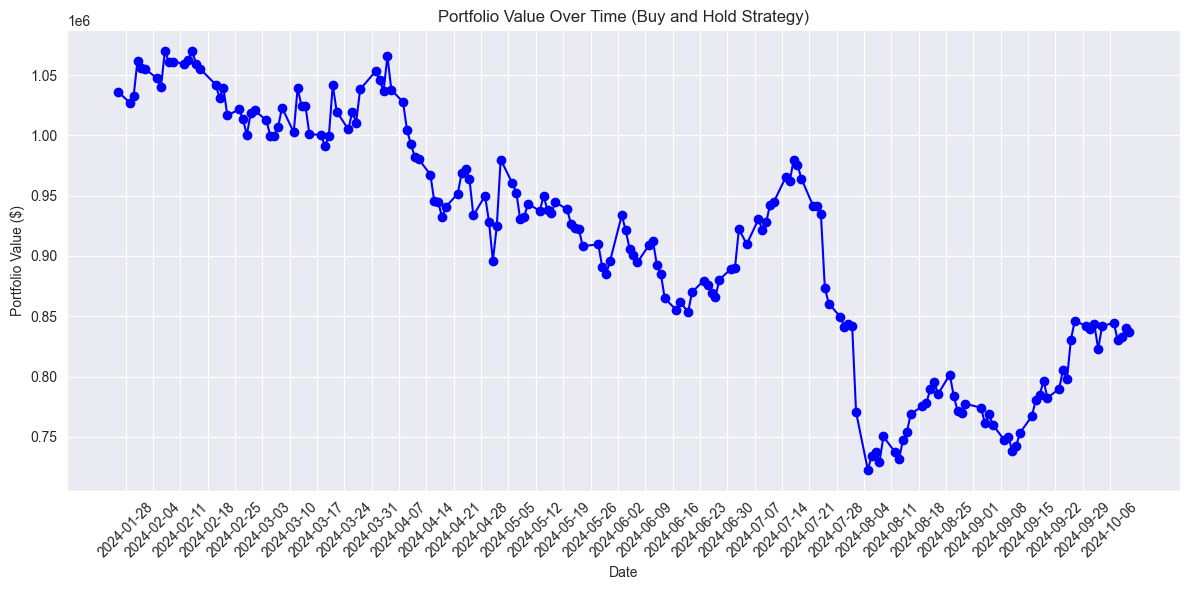

Annual return         -0.259010
Cumulative returns    -0.192749
Annual volatility      0.291997
Sharpe ratio          -0.885534
Calmar ratio          -0.798794
Stability              0.786265
Max drawdown          -0.324251
Omega ratio            0.861795
Sortino ratio         -1.190751
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.232643
Daily value at risk   -0.037814
dtype: float64


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2024-01-26')
end_date = pd.to_datetime('2024-10-11')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
df_account_value = df_account_value.reset_index()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();